In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from game import game

In [3]:
# Run the game 10000 times and store the results
cycles = []
for i in range(10000):
    cycles.append(game())

results = pd.DataFrame(cycles, columns=["cycles", "winner"])
results.to_csv("results.csv", index=False)
results.head(5)

,cycles,winner
0,21,A
1,16,B
2,27,A
3,18,A
4,23,B


In [17]:
# aggregate counts of cycles
results_grouped = results.groupby("cycles", as_index=False).count()
results_grouped.columns = ["cycles", "count"]
results_grouped.head(5)

,cycles,count
0,5,640
1,6,659
2,7,674
3,8,571
4,9,545


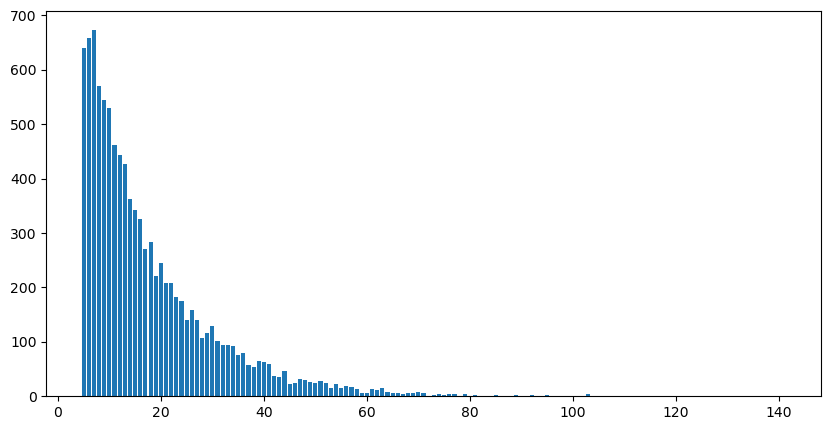

In [21]:

# Plot the number of cycles in the results as a histogram. Make the histogram wider by setting the figsize parameter.
fig, axes = plt.subplots(figsize=(10, 5))
axes.bar(results_grouped["cycles"], height=results_grouped["count"])
plt.show()

In [22]:
# compute the expected number of cycles
expected_cycles = results["cycles"].mean()
print("Expected number of cycles: ", expected_cycles)

Expected number of cycles:  17.8094


In [35]:
# Compute the distribution of the number of cycles
# find the missing values